## Introduction
This code is designed to recommend exam questions to users based on their answer history. For new users, a set of default questions with even proportions across categories is provided. The process involves several steps as follows:

1. **Importing and Loading Data**: Import the necessary libraries and load the quiz question bank and user history data in csv format.

2. **Exploratory Data Analysis (EDA)**: Analyze the data to understand its structure and content. This includes checking for null values and duplicates, and visualizing the distribution of questions by category.

3. **Calculating Mistakes**: Identify questions answered incorrectly by users and calculate the number of mistakes per category. This helps pinpoint areas where users need more practice.

4. **TF-IDF Vectorization and Cosine Similarity**: Transform question descriptions into numerical vectors using TF-IDF (Term Frequency-Inverse Document Frequency). Calculate cosine similarity between these vectors to find questions similar to those that users answered incorrectly.

5. **Determining Proportion**: Based on the user's mistakes, determine the proportion of questions from each category to include in the quiz. This ensures more questions come from categories where users made more mistakes.

6. **Quiz Generation**: Generate a quiz by selecting questions based on the calculated proportions and similarity scores, ensuring a personalized quiz that focuses on the user's weak areas. Additionally, it also filters out questions that users have already answered to prevent repetition.

The aim is to provide a personalized learning experience with content-based filtering approach, helping users improve in areas where they are weak.

## Import Library and Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
link_tps = 'https://raw.githubusercontent.com/Capstone-Buddies/Machine-Learning/main/Dataset/SNBT%20Datasets%20-%20TPS.csv'
link_answer_history_tps = 'https://raw.githubusercontent.com/Capstone-Buddies/Machine-Learning/main/Dataset/SNBT%20Datasets%20-%20Answer_History_TPS.csv'

user_history = pd.read_csv(link_answer_history_tps)
tps_question_data = pd.read_csv(link_tps)

## Exploratory Data Analysis

In [4]:
# Menampilkan beberapa baris pertama dari dataset user_history
# yang berisi riwayat set soal quiz per user ID
print("Data Riwayat Jawaban Pengguna:")
user_history.head()

Data Riwayat Jawaban Pengguna:


,ID_USER,ID_QUESTION,Question_Category,Question_Description,USER_ANSWER,CORRECT_ANSWER,Duration
0,1,139,PU,SMK merupakan pendidikan menengah vokasi yang ...,3,1,94
1,1,229,PBM,(1) Perkembangan dunia IPTEK (Ilmu Pengetahuan...,2,2,45
2,1,295,PPU,"(1) Saat ini, pelaku UMKM harus melek masalah ...",2,3,90
3,1,521,PK,Diketahui bangun datar sebagai berikut:\n1) Pe...,1,1,113
4,1,548,PK,(1) 2264\n(2) 1710\n(3) 496\n(4) 1346\n\nManak...,2,3,117


In [5]:
# Menampilkan beberapa baris pertama dari dataset tps_question_data
# yang berisi bank soal TPS berdasarkan 4 kategori
print("Data Soal TPS:")
tps_question_data.head()

Data Soal TPS:


,ID,Question_Category,Questions_Descriptions,Choice_1,Choice_2,Choice_3,Choice_4,Right_Answer
0,1,PU,Berjalan : berlari,Berkendara,Jalan kaki,Kereta api,Mesin,3
1,2,PU,Lawan kata monoton,Bergerak-gerak,Berulang-ulang,Berubah-ubah,Terus menerus,3
2,3,PU,Lawan kata Mutualisme,Amutualisme,Simbiosisme,Ekosistem,Parasitisme,3
3,4,PU,Padanan kata hipotesis,Sangkaan,Dugaan,Kesimpulan,Kesimpulan awal,3
4,5,PU,Padanan kata pailit,Pelit,Jahat,Bangkrut,Gagal,2


In [6]:
# Menampilkan jumlah kolom dan baris pada dataset
print(tps_question_data.info())
print(user_history.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      600 non-null    int64 
 1   Question_Category       600 non-null    object
 2   Questions_Descriptions  600 non-null    object
 3   Choice_1                600 non-null    object
 4   Choice_2                600 non-null    object
 5   Choice_3                600 non-null    object
 6   Choice_4                600 non-null    object
 7   Right_Answer            600 non-null    int64 
dtypes: int64(2), object(6)
memory usage: 37.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID_USER               350 non-null    int64 
 1   ID_QUESTION           350 non-null    int64 
 2   Question_Ca

In [7]:
# Cek null pada semua kolom
null_check = tps_question_data.isnull().sum()
print("Jumlah nilai null di setiap kolom:")
print(null_check)

# Cek baris soal yang duplikat
duplicate_check = tps_question_data.duplicated(subset=['Questions_Descriptions'])
print(f"\nJumlah duplikat : {duplicate_check.sum()}")

Jumlah nilai null di setiap kolom:
ID                        0
Question_Category         0
Questions_Descriptions    0
Choice_1                  0
Choice_2                  0
Choice_3                  0
Choice_4                  0
Right_Answer              0
dtype: int64

Jumlah duplikat : 0


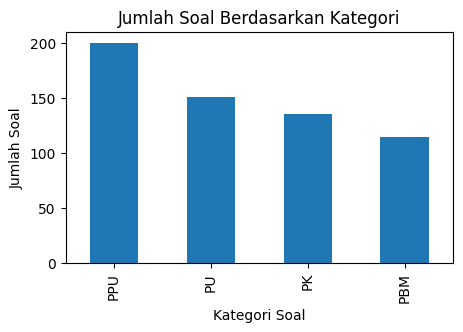

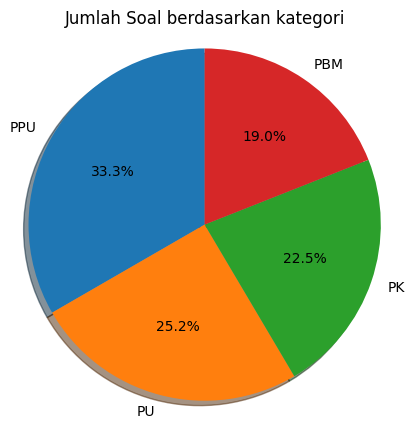

In [8]:
# Visualisasi jumlah soal berdasarkan kategori
plt.figure(figsize=(5, 3))
tps_question_data['Question_Category'].value_counts().plot(kind='bar')
plt.title('Jumlah Soal Berdasarkan Kategori')
plt.xlabel('Kategori Soal')
plt.ylabel('Jumlah Soal')
plt.show()

# Membuat pie chart
sizes = tps_question_data['Question_Category'].value_counts()
labels=sizes.index

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Jumlah Soal berdasarkan kategori')
plt.axis('equal')
plt.show()


## Building Recommender System

In [9]:
# Menghitung jumlah soal yang telah dijawab oleh user untuk setiap kategori
def get_total_questions_per_category(user_data):
    return user_data.groupby('Question_Category').size()

# Menghitung jumlah soal yang salah dijawab oleh user untuk setiap kategori
def get_mistakes_per_category(user_data):
    mistakes = user_data[user_data['USER_ANSWER'] != user_data['CORRECT_ANSWER']]
    return mistakes.groupby('Question_Category').size(), mistakes

In [10]:
# Menghitung similarity antara soal yang salah dijawab dengan soal lain dalam kategori yang sama
def calculate_similarity(mistakes, tps_question_data_filtered):
    combined_descriptions = pd.concat([mistakes['Question_Description'], tps_question_data_filtered['Questions_Descriptions']])

    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(combined_descriptions)

    # Pisahkan TF-IDF matrix untuk user_mistakes dan tps_question_data
    tfidf_user_mistakes = tfidf_matrix[:len(mistakes)]
    tfidf_tps_question_data = tfidf_matrix[len(mistakes):]

    # Hitung cosine similarity
    similarity_matrix = cosine_similarity(tfidf_user_mistakes, tfidf_tps_question_data)

    # Menampilkan similarity matrix dalam bentuk DataFrame
    similarity_df = pd.DataFrame(similarity_matrix, columns=tps_question_data_filtered.index)
    similarity_df.index = mistakes['ID_QUESTION'].values

    # Filter similarity berdasarkan kategori yang sama
    top_similar_questions = {}
    for idx, user_question in enumerate(similarity_df.index):
        category = mistakes.iloc[idx]['Question_Category']
        same_category_indices = tps_question_data_filtered[tps_question_data_filtered['Question_Category'] == category].index
        category_similarities = similarity_df.loc[user_question, same_category_indices]
        top_similar_questions[user_question] = category_similarities.nlargest(10) # mengambil top 10 yang paling mirip

    return top_similar_questions

In [11]:
# Menentukan proporsi soal berdasarkan kategori yang salah dijawab lebih banyak
def determine_proportion(mistakes_per_category, total_questions=10, min_questions_per_category=1):
   # Kategori yang ada
    all_categories = user_data['Question_Category'].unique()

    # Proporsi minimal untuk setiap kategori
    proportion = pd.Series(min_questions_per_category, index=all_categories)

    # Soal yang tersisa setelah distribusi minimal
    remaining_questions = total_questions - proportion.sum()

    # Proporsi berdasarkan kesalahan
    if remaining_questions > 0:
        mistakes_proportion = (mistakes_per_category / mistakes_per_category.sum() * remaining_questions).round().astype(int)
        for cat in mistakes_proportion.index:
            proportion[cat] += mistakes_proportion[cat]

    # Jika masih ada sisa soal yang belum terdistribusi, tambahkan ke kategori dengan kesalahan terbanyak
    remaining_questions = total_questions - proportion.sum()
    if remaining_questions > 0:
        most_mistakes_category = mistakes_per_category.idxmax()
        proportion[most_mistakes_category] += remaining_questions

    return proportion

In [12]:
# Menyusun kuis berdasarkan proporsi dan soal-soal dengan similarity tertinggi
def generate_quiz(proportion, top_similar_questions, mistakes, tps_question_data_filtered, total_questions=10):
    quiz_questions = []

    # Soal yang salah dijawab berdasarkan similarity
    for category in proportion.index:
        questions_needed = proportion[category]
        if category in mistakes['Question_Category'].values:
            for user_question, similar_questions in top_similar_questions.items():
                if mistakes.loc[mistakes['ID_QUESTION'] == user_question]['Question_Category'].values[0] == category:
                    similar_question_ids = [tps_question_data_filtered.loc[idx]['ID'] for idx in similar_questions.index]
                    selected_questions = tps_question_data_filtered[tps_question_data_filtered['ID'].isin(similar_question_ids) &
                                                                   (tps_question_data_filtered['Question_Category'] == category)].head(questions_needed).to_dict('records')
                    quiz_questions.extend(selected_questions)
                    break

    # Soal yang dijawab benar secara acak
    for category in proportion.index:
        if category not in mistakes['Question_Category'].values:
            questions_needed = proportion[category]
            selected_questions = tps_question_data_filtered[tps_question_data_filtered['Question_Category'] == category].sample(questions_needed).to_dict('records')
            quiz_questions.extend(selected_questions)

    # Pastikan hanya ada 10 soal
    quiz_questions = quiz_questions[:total_questions]
    return quiz_questions

In [13]:
# Memeriksa apakah user baru
def is_new_user(user_id, user_history):
    return user_history[user_history['ID_USER'] == user_id].empty

# Menghasilkan soal untuk user baru secara merata per kategori
def generate_questions_for_new_user(tps_question_data, total_questions=10):
    categories = tps_question_data['Question_Category'].unique()
    questions_per_category = total_questions // len(categories)

    quiz_questions = []

    for category in categories:
        selected_questions = tps_question_data[tps_question_data['Question_Category'] == category].sample(questions_per_category).to_dict('records')
        quiz_questions.extend(selected_questions)

    # Jika ada sisa soal yang belum terdistribusi
    remaining_questions = total_questions - len(quiz_questions)
    if remaining_questions > 0:
        extra_questions = tps_question_data[~tps_question_data['ID'].isin([q['ID'] for q in quiz_questions])].sample(remaining_questions).to_dict('records')
        quiz_questions.extend(extra_questions)

    return quiz_questions

In [14]:
# Memfilter soal yang sudah dijawab oleh user sebelumnya
def filter_answered_questions(user_data, tps_question_data):
    answered_question_ids = user_data['ID_QUESTION'].unique()
    return tps_question_data[~tps_question_data['ID'].isin(answered_question_ids)]

In [15]:
# Menyusun kuis sambil menghindari pengulangan soal berturut-turut
def generate_quiz_avoiding_repeats(proportion, top_similar_questions, mistakes, tps_question_data_filtered, last_questions, total_questions=10):
    quiz_questions = []
    used_questions = set(last_questions)  # Set untuk menyimpan soal yang sudah digunakan dalam kuis sebelumnya

   # Soal yang salah dijawab berdasarkan similarity
    for category in mistakes_per_category.index:
        questions_needed = proportion[category]
        for user_question, similar_questions in top_similar_questions.items():
            if mistakes.loc[mistakes['ID_QUESTION'] == user_question]['Question_Category'].values[0] == category:
                 similar_question_ids = [tps_question_data_filtered.loc[idx]['ID'] for idx in similar_questions.index]
                 selected_questions = tps_question_data_filtered[tps_question_data_filtered['ID'].isin(similar_question_ids) &
                                                                (tps_question_data_filtered['Question_Category'] == category) &
                                                                (~tps_question_data_filtered['ID'].isin(used_questions))].head(questions_needed).to_dict('records')
                 quiz_questions.extend(selected_questions)
                 used_questions.update([q['ID'] for q in selected_questions])
                 break

    # Soal yang dijawab benar secara acak
    for category in proportion.index:
        if category not in mistakes_per_category.index:
            questions_needed = proportion[category]
            selected_questions = tps_question_data_filtered[tps_question_data_filtered['Question_Category'] == category].sample(questions_needed).to_dict('records')
            quiz_questions.extend(selected_questions)

    # Pastikan hanya ada 10 soal
    quiz_questions = quiz_questions[:total_questions]
    return quiz_questions

In [16]:
# Merekomendasikan soal kepada user
def recommend_questions_for_user(user_id, user_history, tps_question_data, last_questions, total_questions=10):
    if is_new_user(user_id, user_history):
        print("User baru, generate soal secara merata per kategori.")
        quiz_questions = generate_questions_for_new_user(tps_question_data, total_questions)

    else:
        user_data = user_history[user_history['ID_USER'] == user_id]

        # Cek jika semua soal sudah pernah dijawab oleh user
        if len(user_data['ID_QUESTION'].unique()) == len(tps_question_data):
            tps_question_data_filtered = tps_question_data.copy()
        else:
            tps_question_data_filtered = filter_answered_questions(user_data, tps_question_data)

        total_questions_per_category = get_total_questions_per_category(user_data)

        mistakes_per_category, mistakes = get_mistakes_per_category(user_data)

        top_similar_questions = calculate_similarity(mistakes, tps_question_data_filtered)

        proportion = determine_proportion(mistakes_per_category, total_questions)
        print("\nProporsi soal yang akan ditampilkan untuk setiap kategori:")
        print(proportion)

        quiz_questions = generate_quiz_avoiding_repeats(proportion, top_similar_questions, mistakes, tps_question_data_filtered, last_questions, total_questions)

    # Membuat DataFrame dari quiz_questions
    quiz_df = pd.DataFrame(quiz_questions)
    print("\nSoal yang akan ditampilkan dalam kuis:")
    display(quiz_df)

    return [q['ID'] for q in quiz_questions]  # Mengembalikan ID soal yang digunakan dalam kuis

## Model Implementation

In [17]:
# Menentukan ID user
user_id = 1
last_questions = []
user_data = user_history[user_history['ID_USER'] == user_id]

# Menghitung jumlah soal untuk setiap kategori yang telah dijawab oleh user (untuk pengecekan)
total_questions_per_category = get_total_questions_per_category(user_data)
print("Jumlah soal untuk setiap kategori yang telah dijawab oleh user:")
display(total_questions_per_category)

# Menghitung jumlah soal yang salah dijawab oleh user untuk setiap kategori (untuk pengecekan)
mistakes_per_category, mistakes = get_mistakes_per_category(user_data)
print("\nJumlah soal yang salah dijawab oleh user untuk setiap kategori:")
display(mistakes_per_category)

# Menampilkan soal yang salah dijawab user dalam bentuk tabel
print("\nSoal yang salah dijawab oleh user:")
mistakes_table = mistakes[['ID_QUESTION', 'Question_Category', 'Question_Description']]
display(mistakes_table)

# Mengupdate last_questions menjadi set soal yang di berikan ke user
last_questions = recommend_questions_for_user(user_id, user_history, tps_question_data, last_questions)

Jumlah soal untuk setiap kategori yang telah dijawab oleh user:


Question_Category
PBM    3
PK     2
PPU    4
PU     1
dtype: int64


Jumlah soal yang salah dijawab oleh user untuk setiap kategori:


Question_Category
PBM    1
PK     1
PPU    2
PU     1
dtype: int64


Soal yang salah dijawab oleh user:


,ID_QUESTION,Question_Category,Question_Description
0,139,PU,SMK merupakan pendidikan menengah vokasi yang ...
2,295,PPU,"(1) Saat ini, pelaku UMKM harus melek masalah ..."
4,548,PK,(1) 2264\n(2) 1710\n(3) 496\n(4) 1346\n\nManak...
6,182,PBM,"(1) Selain itu, mereka juga mengumumkan kerusa..."
7,277,PPU,Akibatnya Indonesia tidak bisa membeli persenj...



Proporsi soal yang akan ditampilkan untuk setiap kategori:
PU     2
PBM    2
PPU    4
PK     2
dtype: int64

Soal yang akan ditampilkan dalam kuis:


,ID,Question_Category,Questions_Descriptions,Choice_1,Choice_2,Choice_3,Choice_4,Right_Answer
0,174,PBM,(1) Pusat Permodelan Matematika dan Simulasi (...,setelah kalimat 2,setelah kalimat 3,setelah kalimat 4,setelah kalimat 5,0
1,175,PBM,(1) Pusat Permodelan Matematika dan Simulasi (...,ketika,sebelum,saat,setelah,3
2,478,PK,"Dari 5 angka 1, 2, 3, 4 dan 5 akan dibentuk bi...",30,48,60,72,1
3,493,PK,"Rata-rata 15 bilangan adalah 13,4. Rata-rata 8...",10,11,12,13,1
4,267,PPU,(1) Sebagian besar orang sering mengeluh karen...,Impak,Efek,Imbas,Akibat,0
5,273,PPU,(1) Sebagian besar orang sering mengeluh karen...,6,7,9,13,3
6,274,PPU,(1) Sebagian besar orang sering mengeluh karen...,Kalimat (4),Kalimat (5),Kalimat (6),Kalimat (8),2
7,294,PPU,(1) Perkembangan dunia Ilmu Pengetahuan dan Te...,menghilangkan kata yang,"menambahkan tanda koma (,) setelah kata teknologi",mengubah penulisan kata silaturahmi menjadi ka...,"menambahkan tanda koma (,) sebelum kata ketika...",3
8,86,PU,Industri tekstil dan garmen saat ini menjadi i...,Setiap penduduk dapat memproduksi garmen.,Setiap penduduk membutuhkan produk pakaian jadi.,Setiap penduduk dapat memulai usaha di sektor ...,Setiap penduduk harus bekerja di industri teks...,1
9,87,PU,Industri tekstil dan garmen saat ini menjadi i...,Industri tekstil dan garmen menyerap 250 juta ...,Industri tekstil termasuk tiga besar sektor ma...,Industri tekstil berhasil mengekspor produk se...,Industri tekstil merupakan kebutuhan pokok sel...,1
